<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module6/M6_1/2_Location_Problem_Advanced_guided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Optimization: Warehouse Location (advanced) (guided)
---------------------------------------------------
**OPIM 5641: Business Decision Modeling - University of Connecticut**

Please refer to Powell Ch. 8 for more details and examples.

IPOPT documentation: https://coin-or.github.io/Ipopt/

-----------------------------------------------

In [ ]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import numpy as np

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        #!apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

***Location Problem (revisited).*** Return to the simple Kilroy Paper
Company example. Upon further
consideration, the logistics manager points out that the
trucks do not make an equal number of trips to the
various stores. Thus, a better proxy for total distribution
costs would be obtained by weighting the distance from 
distribution center to store k by the annual number of trips
to store $k$ (represented as $n_k$). The expanded set of input
data is as follows:

Site ($k$)| $x_k$| $y_k$| $n_k$
---|---|---|---
1| 5| 41| 12
2| 20| 10| 20
3| 44| 48| 15
4| 60| 58| 27
5| 100| 4| 8
6| 138| 80| 16
7| 150| 40| 10
8| 170| 18| 18
9| 182| 2| 25
10| 190| 56| 14

1. Find the optimal location for Kilroy’s distribution center in
this expanded version of the problem.
2. What is the optimal value of the objective function?

## Background (2D Distances)
***Same as before...***

**What is our objective?** To minimize this distance between the DC and the stores. We need to predict the XY coordinates of the DC.

What is a good measure of distance? The Euclidean distance formula.

For each store $k$, we can calculate the pairwise distance between the store and the DC.

$D_k(x,y) = \sqrt{(x-x_k)^2 + (y-y_k)^2}$

And we will repeat this 10 times (one for each store, DC pair) and try to minimize this quantity.

$f(x,y)=\Sigma_{k=1}^{10}D_k(x,y)$

***This is new...***
NOW! We have some more information here - the number of trips that each store requires. How do we handle this? Easy. Use the number of trips as a weight - this will force the model to prioritize it.

$f(x,y)=\Sigma_{k=1}^{10}D_k(x,y)*n_k$

where $n_k$ is the number of trips.

That's it! Now let's go build a model.

## Visualizing the old problem
Dots are all the same size. No weighting as a function of number of trips ($N$).

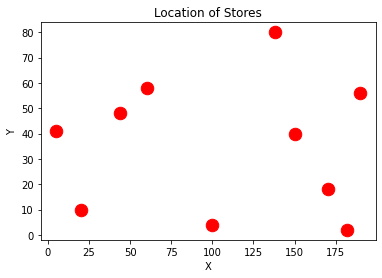

In [ ]:
# specify X and Y coords of each store
import numpy as np
X = np.array([5, 20, 44, 60, 100, 138, 150, 170, 182, 190])
Y = np.array([41, 10, 48, 58, 4, 80, 40, 18, 2, 56])

# show a map!
# with pylab, we can cut down on some of the typing...
from pylab import *
plot(X,Y, '.', markersize=25, color='red') # '.' plots them as dots on a scatterplot
title('Location of Stores')
xlabel('X')
ylabel('Y')
plt.show() # gets rid of annoying text

## Visualizing the new problem
Now the dots should all be different sizes - because they are weighted. So now we will be searching for a WEIGHTED CENTROID among this point cloud (mass).

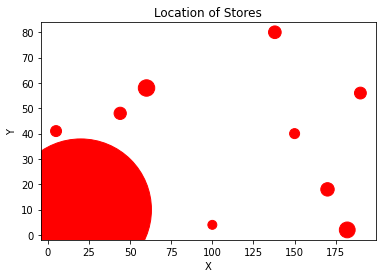

In [ ]:
# specify X, Y and N coords of each store
import numpy as np
X = np.array([5, 20, 44, 60, 100, 138, 150, 170, 182, 190])
Y = np.array([41, 10, 48, 58, 4, 80, 40, 18, 2, 56])
N = np.array([12, 20, 15, 27, 8, 16, 10, 18, 25, 14])

# note how consistent we are with our naming convention...

# show a map!
# see how we can incorporate size here?
from pylab import *
scatter(X,Y, s=N*10, color='red') # '.' plots them as dots on a scatterplot... as a function of size
title('Location of Stores') # here is the example: https://datavizpyr.com/make-bubble-plot-in-python-with-matplotlib/#:~:text=Bubble%20plot%20is%20a%20scatterplot,us%20load%20Pandas%20and%20Matplotlib.
xlabel('X')
ylabel('Y')
plt.show() # gets rid of annoying text

Try to visualize where you think the dot should go...

# ConcreteModel

In [ ]:
# declare the model
model = ConcreteModel()

# Declare Decision Variables
Our decision variables and constraints are going to be a bit intertwined. We want to minimize the distances from each of the 10 stores to the distribution center. So we need to find a coordinate corresponding to the lat/lon (X/Y) coordinate of the distribution center: $x_k$ and $y_k$.

In [ ]:
# number of stores (there are 10)
n_points = len(X)

# declare decision variables
# remember, we should  intialize a value here (you can try different ones)
# and we need to provide real bounds to help convergence
model.Xcoord = Var(domain=Reals,bounds = (0,200), initialize=0)
model.Ycoord = Var(domain=Reals, bounds = (0,100), initialize=0)

# and this is to store the intermediate Distances as we try to find optimal Xcoord and Ycoord
model.Dist = Var([i for i in range(n_points)],domain=Reals, initialize=0)

model.pprint()

1 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :     0 :  None : False : False :  Reals
          9 :  None :     0 :  None : False : False :  Reals
    Xcoord : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : St

In [ ]:
[i for i in range(n_points)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
for i in range(n_points):
  print(i)

0
1
2
3
4
5
6
7
8
9


For now, we have declared two decision variables and 10 other distance-related variables that are intermediate calculations that will be used in a moment to calculate the objective function.

At this point, we haven't shown how `model.Xcoord` ($x_k$) and `model.Ycoord` ($y_k$) - the centroids of the distribution center - have been used yet. But we set up a helpful skeleton to fill everything in.

# Declare Constraints
Now, this is where your distance function is going to live! You are going to enforce that the distance between the distribution center and the $i$th warehouse of interest is accounted for as such.

**But now we have $N$ to consider as well!** For each of the ten points - you need to account for the number of trips... so you are WEIGHTING by the number of trips!


In [ ]:
# Constraints
model.constraints = ConstraintList()

# Pairwise values from DC to store (loops 10 times)
for i in range(n_points):
  x = X[i]
  y = Y[i]
  n = N[i] # THIS IS NEW!!!

  # THIS IS NEW!!! notice how n makes an appearance now
  model.constraints.add(model.Dist[i] == n*((model.Xcoord-x)**2 + (model.Ycoord-y)**2)**0.5)
# show the model you've created
model.pprint()

2 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :  

# Objective Function
Now, you have filled in those 10 `Dist` (distance) placeholders between all of the warehouses (X,y - dynamically updated in the for loop) and the distribution center (Xcoord, Ycoord).

In [ ]:
# how does += work?
# it adds the new value to the existing value,
# and overwrites it
# see if you can do this math!
obj_expr = 0
myDist = [10,12,62,37,84,59,60,47,88,91]
for i in range(10):
  obj_expr += myDist[i]
  print(obj_expr)

10
22
84
121
205
264
324
371
459
550


In [ ]:
# declare objective
# we are trying to minimize the distance
obj_expr = 0 # intialize the objective as a 0...
for i in range(n_points):
  obj_expr += model.Dist[i]
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# show the model you've created
model.pprint()

2 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :  

Now you can clearly see that you are trying to minimize the distances - and each `Dist[0]` is the Euclidean distance between the individual warehouse and the distribution center (`model.Xcoord`, `model.Ycoord` your decision variables)

# Solve!

Now let's run it!

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# show the results
print("Objective value = ", model.error())
print("Xcoord = ", model.Xcoord())
print("Ycoord = ", model.Ycoord())

    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations
        Exceeded.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 12
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.003103494644165
# -----------------------------

Great! Now show the map with your new Distribution Center (DC) on it!

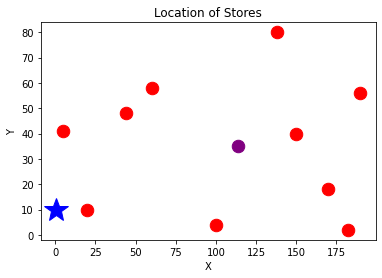

In [ ]:
# show a map!
from pylab import *
plot(X,Y, '.', markersize=25, color='red') # '.' plots them as dots on a scatterplot
title('Location of Stores')
xlabel('X')
ylabel('Y')
# let's add the new distribution as a big blue star
plot(model.Xcoord(),model.Ycoord(), '*', markersize=25, color='blue') # '.' plots them as dots on a scatterplot
# let's add the OLD ANSWER (approximate) as a purple dot
plot(114,35, '.', markersize=25, color='purple')
plt.show() # gets rid of annoying text

# What do you see?
It looks like we have found the centroid of the point mass, as a function of Euclidean distance. We can compare this with the old solution... which was X = 114 and y = 35.... the new values are X = 107 and y = 37 (approximately).

# On Your Own...
Why don't we try adding a monster dot in the bottom left to see how the new solution would move in the new version of the problem? Like X = 5, Y = 20 and N = 10000. The star should go on top of this dot - you should be able to visualize this in your head!
